# Neural network training tricks II

From [fast.ai](https://course.fast.ai/) course for year 2018.

Fast.ai [book](https://github.com/fastai/fastbook).

CIFAR10 image classification

## Google Colab

Some tricks from [blog post](https://medium.com/@robertbracco1/configuring-google-colab-like-a-pro-d61c253f7573):

In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

Use `wget` to download datasets to Google Drive - it's faster:

In [ ]:
# ! wget -c -P '/content/drive/My Drive/Colab Notebooks/data/' <URL>

Use [Gdown](https://github.com/wkentaro/gdown) for downloading public Google Drive files

In [ ]:
# ! pip install gdown -q
# ! gdown <URL>

Run Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
# %tensorboard --logdir logs

## Configuration

Imports

In [ ]:
import numpy as np
from itertools import islice
import copy
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt

Configuration

In [ ]:
NUM_CLASSES = 10
BATCH_SIZE = 32

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Dataset

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [ ]:
train_dset = datasets.CIFAR10(root='.', train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root='.', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

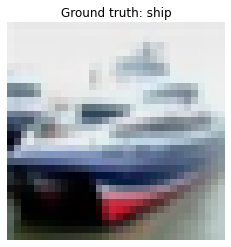

In [ ]:
dataset_show_image(test_dset, 1)

## Model

Darknet from YOLOv3, [arXiv:1804.02767 [cs.CV]](https://arxiv.org/abs/1804.02767).

In [ ]:
def init_linear(m):
    nn.init.kaiming_normal_(m.weight, a=0.1, mode='fan_out', nonlinearity='leaky_relu')
    if m.bias is not None: nn.init.zeros_(m.bias)

In [ ]:
class ConvBlock(nn.Sequential):
    def __init__(self, filters1, filters2, kernel_size, stride=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(filters1, filters2, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(filters2),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
    
    def reset_parameters(self):
        init_linear(self[0])
        self[1].reset_parameters()

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, filters):
        super().__init__()
        filters2 = filters // 2
        self.residual = nn.Sequential(
            ConvBlock(filters, filters2, 1),
            ConvBlock(filters2, filters, 3)
        )

    def forward(self, x):
        return x + self.residual(x)

In [ ]:
class Darknet(nn.Sequential):
    def __init__(self, repetitions, classes):
        super().__init__()
        
        layers = [ConvBlock(3, 32, 3)]
        
        prev_filters = 32
        for rep in repetitions:
            filters = prev_filters * 2
            layers.append(ConvBlock(prev_filters, filters, 3, stride=2))
            layers += [ResidualBlock(filters) for _ in range(rep)]
            prev_filters = filters
        
        layers += [nn.AdaptiveAvgPool2d(1),
                   nn.Flatten(),
                   nn.Linear(prev_filters, classes),
                   nn.LogSoftmax(1)]
        
        super().__init__(*layers)
        self.reset_parameters()
        
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, ConvBlock) or isinstance(m, nn.Linear):
                m.reset_parameters()

In [ ]:
model = Darknet([1, 2, 2, 2], NUM_CLASSES).to(DEVICE) 

## Test time augmentation

In [ ]:
tta_transform = transforms.Compose([
    transforms.Lambda(lambda img: [img, TF.hflip(img)]),
    transforms.Lambda(lambda imgs: torch.stack([transforms.ToTensor()(img) for img in imgs])) 
])

In [ ]:
class TTA:
    def __init__(self, transform):
        self.transform = transform
    
    def begin_eval(self, dset):
        self.dset = dset
        self.orig_transform = self.dset.transform
        self.dset.transform = self.transform
    
    def process_batch(self, learner):
        x = learner.X
        self.bs, self.n_imgs, c, h, w = x.size()
        learner.X = x.view(-1, c, h, w)
    
    def process_prediction(self, learner):
        probs = torch.exp(learner.Y_pred)
        probs_tta = probs.view(self.bs, self.n_imgs, -1).mean(1)
        learner.Y_pred = torch.log(probs_tta)
    
    def end_eval(self):
        self.dset.transform = self.orig_transform

## Learner

In [ ]:
class Accuracy:
    def __init__(self, counter=None):
        self.counter = counter if counter else self
        self.reset()
    
    def count_correct(self, pred, y):
        return (pred == y).float().sum()
    
    def process_prediction(self, learner):
        y = learner.Y
        batch_size = y.size(0)
        labels_pred = torch.argmax(learner.Y_pred, -1)
        self.num_correct += self.counter.count_correct(labels_pred, y)
        self.num_samples += batch_size
    
    def get_average(self):
        return self.num_correct / self.num_samples
    
    def reset(self):
        self.num_samples = 0
        self.num_correct = 0

In [ ]:
class AverageLoss:
    def __init__(self):
        self.reset()
    
    def process_loss(self, batch_size, batch_loss):
        self.total_loss += batch_size * batch_loss
        self.num_samples += batch_size
    
    def get_average(self):
        return self.total_loss / self.num_samples
    
    def reset(self):
        self.total_loss = 0.0
        self.num_samples = 0

In [ ]:
class AccumulateSmoothLoss:
    def __init__(self, smooth_f=0.05, diverge_th=5):
        self.diverge_th = diverge_th
        self.smooth_f = smooth_f
        self.reset()
    
    def process_loss(self, batch_size, loss):
        if not self.losses:
            self.best_loss = loss
        else:
            if self.smooth_f > 0:
                loss = self.smooth_f * loss + (1. - self.smooth_f) * self.losses[-1]
            if loss < self.best_loss:
                self.best_loss = loss
        
        self.losses.append(loss)
        if loss > self.diverge_th * self.best_loss:
            raise StopIteration
    
    def get_losses(self):
        return self.losses
    
    def reset(self):
        self.losses = []

In [ ]:
class Learner:
    def __init__(self, model, loss, optimizer, train_loader, val_loader,
                 epoch_scheduler=None, batch_scheduler=None, tta=None):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epoch_scheduler = epoch_scheduler
        self.batch_scheduler = batch_scheduler
        self.tta = tta
        self.reset_history()
    
    
    def reset_history(self):
        self.train_losses = []
        self.val_losses = []
        self.lrs = []
    

    def run_callbacks(self, cbs, fname, *args):
        for cb in cbs:
            f = getattr(cb, fname, None)
            if f: f(*args)
    

    def iterate(self, loader, cbs=[], backward_pass=False):
        for X, Y in loader:
            self.X, self.Y = X.to(DEVICE), Y.to(DEVICE)
            self.run_callbacks(cbs, 'process_batch', self)
            self.Y_pred = self.model(self.X)
            self.run_callbacks(cbs, 'process_prediction', self)
            batch_loss = self.loss(self.Y_pred, self.Y)
            if backward_pass: self.backward_pass(batch_loss)
            batch_size = self.X.size(0)
            self.run_callbacks(cbs, 'process_loss', batch_size, batch_loss.item())
    

    def backward_pass(self, batch_loss):
        self.optimizer.zero_grad()
        batch_loss.backward()
        self.optimizer.step()
        
        if self.batch_scheduler:
            self.lrs.append(self.batch_scheduler.get_last_lr()[0])
            self.batch_scheduler.step()
    

    def train_for_epoch(self):
        self.model.train()
        
        cbs = [AverageLoss(), Accuracy(self.mixup), self.mixup]
        self.iterate(self.train_loader, cbs, backward_pass=True)
        
        train_loss, train_acc = [cb.get_average() for cb in cbs[:2]]
        self.train_losses.append(train_loss)
        print(f'train loss {train_loss:.3f}, train accuracy {train_acc:.3f},', end=' ')
    

    def eval_on_validation(self):
        self.model.eval()
        
        if self.tta: self.tta.begin_eval(self.val_loader.dataset)
        cbs = [self.tta, AverageLoss(), Accuracy()]
        with torch.no_grad():
            self.iterate(self.val_loader, cbs)
        if self.tta: self.tta.end_eval()
        
        val_loss, val_acc = [cb.get_average() for cb in cbs[-2:]]
        self.val_losses.append(val_loss)
        print(f'val loss {val_loss:.3f}, val accuracy {val_acc:.3f}')
    
    
    def set_learning_rate(self, lr):
        new_lrs = [lr] * len(self.optimizer.param_groups)
        for param_group, new_lr in zip(self.optimizer.param_groups, new_lrs):
            param_group["lr"] = new_lr
    
    
    def lr_find(self, start_lr, end_lr, num_iter):
        model_state = copy.deepcopy(self.model.state_dict())
        optimizer_state = copy.deepcopy(self.optimizer.state_dict())
        
        self.model.train()
        self.set_learning_rate(start_lr)

        gamma = (end_lr / start_lr)**(1 / num_iter)
        self.batch_scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma)
        
        cbs = [AccumulateSmoothLoss()]
        try:
            self.iterate(islice(self.train_loader, num_iter), cbs, backward_pass=True)
        except StopIteration:
            print("Stopping early, the loss has diverged")
        self.batch_scheduler = None
        
        self.model.load_state_dict(model_state)
        self.optimizer.load_state_dict(optimizer_state)
        
        self.train_losses = cbs[0].get_losses()
        self.plot_lr_find()
        self.reset_history()
    

    def fit(self, epochs):
        for i in range(epochs):
            print(f'{i+1}/{epochs}:', end=' ')
            self.train_for_epoch()
            self.eval_on_validation()
            
            if self.epoch_scheduler:
                self.lrs.append(self.epoch_scheduler.get_last_lr()[0])
                self.epoch_scheduler.step()
    

    def plot_losses(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        epochs = np.arange(1, len(self.train_losses)+1)
        ax.plot(epochs, self.train_losses, '.-', label='train')
        ax.plot(epochs, self.val_losses, '.-', label='val')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()
        plt.show()
    

    def plot_lr_find(self, skip_start=10, skip_end=5):
        def split_list(vals, skip_start, skip_end):
            return vals[skip_start:-skip_end] if skip_end > 0 else vals[skip_start:]
        
        lrs = split_list(self.lrs, skip_start, skip_end)
        losses = split_list(self.train_losses, skip_start, skip_end)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(lrs, losses, '.-')
        ax.set_xscale('log')
        ax.set_xlabel('Learning rate')
        ax.set_ylabel('Loss')
        plt.show()

In [ ]:
def plot_lrs(lrs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    batches = np.arange(1, len(lrs)+1)
    ax.plot(batches, lrs)
    ax.set_xlabel('batch')
    ax.set_ylabel('lr')
    plt.show()

## Training

In [ ]:
model.reset_parameters()

In [ ]:
loss = nn.NLLLoss()

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [ ]:
learner = Learner(model, loss, optimizer, train_loader, test_loader)

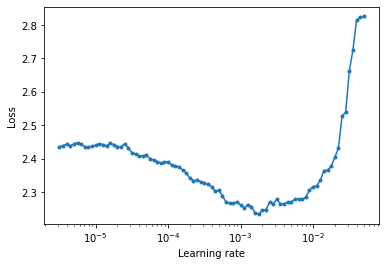

In [ ]:
learner.lr_find(1e-6, 1e-1, num_iter=100)

SGDR leraning rate annealing, [arXiv:1608.03983 [cs.LG]](https://arxiv.org/abs/1608.03983). Implemented in PyTorch: [torch.optim.lr_scheduler.CosineAnnealingWarmRestarts](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CosineAnnealingWarmRestarts).

In [ ]:
learner.set_learning_rate(1e-3) # set maximal learning rate
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=len(train_loader), T_mult=2)
learner.batch_scheduler = scheduler

In [ ]:
EPOCHS = 1+2+4+8

In [ ]:
learner.fit(EPOCHS)

1/15: train loss 1.465, train accuracy 0.468, val loss 1.015, val accuracy 0.629
2/15: train loss 1.171, train accuracy 0.583, val loss 0.849, val accuracy 0.700
3/15: train loss 0.805, train accuracy 0.718, val loss 0.667, val accuracy 0.762
4/15: train loss 0.895, train accuracy 0.689, val loss 0.737, val accuracy 0.744
5/15: train loss 0.723, train accuracy 0.750, val loss 0.667, val accuracy 0.774
6/15: train loss 0.590, train accuracy 0.794, val loss 0.504, val accuracy 0.828
7/15: train loss 0.505, train accuracy 0.826, val loss 0.479, val accuracy 0.835
8/15: train loss 0.686, train accuracy 0.763, val loss 0.645, val accuracy 0.779
9/15: train loss 0.616, train accuracy 0.786, val loss 0.552, val accuracy 0.812
10/15: train loss 0.549, train accuracy 0.811, val loss 0.513, val accuracy 0.824
11/15: train loss 0.491, train accuracy 0.830, val loss 0.469, val accuracy 0.839
12/15: train loss 0.430, train accuracy 0.851, val loss 0.424, val accuracy 0.855
13/15: train loss 0.380, 

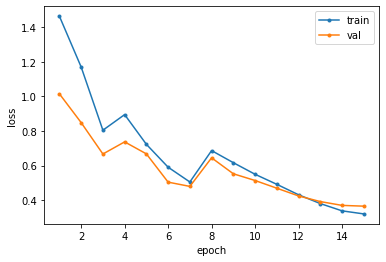

In [ ]:
learner.plot_losses()

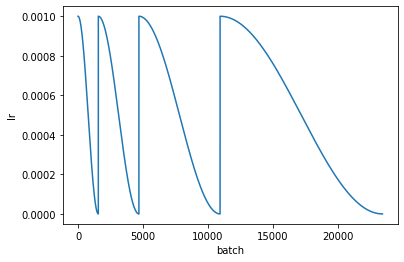

In [ ]:
plot_lrs(learner.lrs)

In [ ]:
tta = TTA(tta_transform)

In [ ]:
learner.tta = tta

In [ ]:
learner.eval_on_validation()

val loss 0.337, val accuracy 0.882
